# Week 6 – Challenges

## Accident database enrichment

The database of accidents has been downloaded from a government website. It does not have any adresses geolocalized. Your goal in this challenge is get use to update yoru odata with an API. We will use Baidu API to query the adresses and obtain a location. 

### API call 

🤔 follow the steps from the course to get your own API key and try to get query baidu to get an an adress geolocalized. Store the result in longitude and latitude variables

In [3]:
# some import might be useful
import requests
from coords import gcj02_decrypt
baidu_api_url = 'https://api.map.baidu.com/'
baidu_api_endpoint = 'geocoding/v3/'

with open('../baidu_ak',encoding = 'utf-8') as fp:
    baidu_application_key = fp.read().strip()

In [4]:
xnode = '上海大学'

def get_location(xnode):
    address = {
        'city':'上海市',
        'address': xnode
    }

    params = {
        'city' : address['city'],
        'address' : address['address'],
        'output' : 'json',
        'ret_coordtype' : 'gcj02ll',
        'ak' : baidu_application_key
    }

    query_parameters = '&'.join([f'{k}={v}' for k , v in params.items()])
    query = f'{baidu_api_url}{baidu_api_endpoint}?{query_parameters}'

    r = requests.get(query)
    data = r.json()

    latitude = data['result']['location']['lat']
    longitude = data['result']['location']['lng']
    new_latitude, new_longitude = gcj02_decrypt(latitude,longitude)

    return [new_longitude,new_latitude]
# CODE FROM THE COURSE WEEK6 COURSE PART 1


🤔 now that the address is geolocalized we still need to unshift the coordinate. Right now the coordinate are in GCJ02 and we need them in WG84. Use the code from the course to unshift it. 

In [5]:
[new_longitude, new_latitude] = get_location(xnode)
print(new_longitude, new_latitude)

121.39099929591353 31.316107699825157



### Use pandas to Query the database of addresses

Now that you are capable of getting one query right, let's try to query baidu for 100 accidents that happened on a street of your choice. 

the table is called __`roadtraffic`__ and the field are as follows:
- `ìd`	INTEGER	NULL	
- `address`	TEXT(255,0)	NULL	
- `date`	TEXT(255,0)	NULL	
- `cause`	TEXT(255,0)	NULL	
- `longitude`	real	Null	
- `latitude`	real	Null	
- `done`	TEXT	0	

🤔 step 1 create a pandas dataframe with a query in accidents.sqlite on the table `roadtraffic` selecting only the rows where `done` is not 1 and display the first 5 lines

In [8]:
# some import might be useful

import pandas as pd
import sqlite3

sql_cmd = ' SELECT * FROM roadtraffic'

conn = sqlite3.connect('../data/accidents.sqlite')

df = pd.read_sql(sql = sql_cmd ,con = conn)

df.head(5)

,id,address,date,cause,longitude,latitude,done
0,3101010200700018,西藏南路、方浜西路,2007-06-25 12:32:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
1,3101010200700068,南京西路、新昌路,2007-06-15 21:00:00.0,上海市公安局黄浦分局交通警察支队机动责任区,NaN,NaN,0
2,3101010200700079,复兴东路、四牌楼路,2007-06-15 05:30:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
3,3101010200700081,南仓街82弄,2007-01-21 11:00:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
4,3101010200700100,四川中路、香港路,2007-06-23 08:45:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0


🤔 step 2 select the rows where your street address name is in the address field as a new dataframe

In [9]:
df_nj = df.loc[df.address.str.contains('南京东路')]

🤔 step 3 for each of these rows, query baidu to location AND unshift it to WGS84. Save the result in the new dataframe you just created

In [10]:
import re 
df.address.apply(lambda s: re.sub(r'[东南西北]?约\d+米','',str(s)))

0         西藏南路、方浜西路
1          南京西路、新昌路
2         复兴东路、四牌楼路
3            南仓街82弄
4          四川中路、香港路
            ...    
935892     水电路进汶水东路
935893    同心路出中山北一路
935894     安汾路出江杨南路
935895      四平路进吴淞路
935896      水电路进广中路
Name: address, Length: 935897, dtype: object

In [15]:
while len(df_nj[df_nj.done != 1]) > 0:
    row = df_nj[df_nj.done != 1].sample(1)
    row_id = row.index.to_list()[0]
    long,lat = get_location(row.address)
    df_nj.at[row_id,'longitude'] = long
    df_nj.at[row_id,'latitude'] = lat
    df_nj.at[row_id,'done'] = 1

In [22]:
df_nj

,id,address,date,cause,longitude,latitude,done
8,3101010200700191,南京东路外滩,2007-06-29 00:45:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,121.479390,31.240344,1
69,3101010200700919,国货路、南京东路,2007-07-15 22:20:00.0,上海市公安局黄浦分局交通警察支队机动责任区,121.479159,31.239069,1
135,3101010200701618,河南中路、南京东路,2007-07-31 11:05:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,121.479159,31.239069,1
144,3101010200701676,南京东路、中山东一路,2007-07-31 16:00:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,121.485813,31.239007,1
204,3101010200702278,中山东一路、南京东路,2007-08-16 13:50:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,121.485813,31.239007,1
...,...,...,...,...,...,...,...
166836,3101019201608737,南京东路进浙江中路西约10米,2016-07-21 10:35:00.0,上海市公安局黄浦分局交通警察支队第二责任区,121.474233,31.236566,1
166956,3101019201609835,南京东路中山东一路西约50米,2016-08-16 23:40:00.0,上海市公安局黄浦分局交通警察支队隧桥责任区,121.485813,31.239007,1
167162,3101019201611869,河南中路南京东路东约30米,2016-09-30 22:20:00.0,上海市公安局黄浦分局交通警察支队第二责任区,121.470965,31.237853,1
167195,3101019201612186,南京东路湖北路西约0米,2016-09-21 22:20:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,121.479159,31.239069,1


### create a geopandas dataframe 

🤔 step 4 create a geopandas dataframe from the pandas dataframe. initialize the geometry column using the geopandas function [points_from_xy](https://geopandas.org/docs/reference/api/geopandas.points_from_xy.html?highlight=points_from#geopandas.points_from_xy) and initialize the crs (the projection) to 4326 (you can check it on [epsg.io/4326](https://epsg.io/4326))

In [23]:
import geopandas as gpd

In [25]:
gdf = gpd.GeoDataFrame(df_nj,geometry = gpd.points_from_xy(df_nj.longitude,df_nj.latitude),crs = 4326)

🤔 step 5 plot the points using the plot function 

<AxesSubplot:>

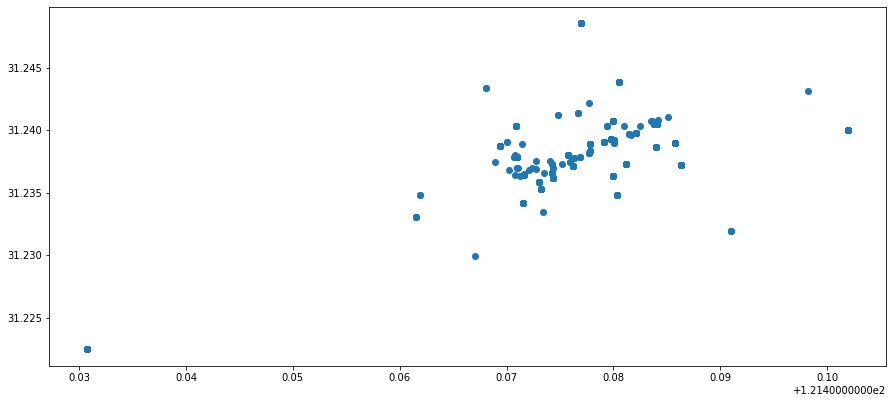

In [26]:
gdf.plot(figsize = (15,10))

🤔 step 6 optionnal, plot using a shanghai basemap like in the course

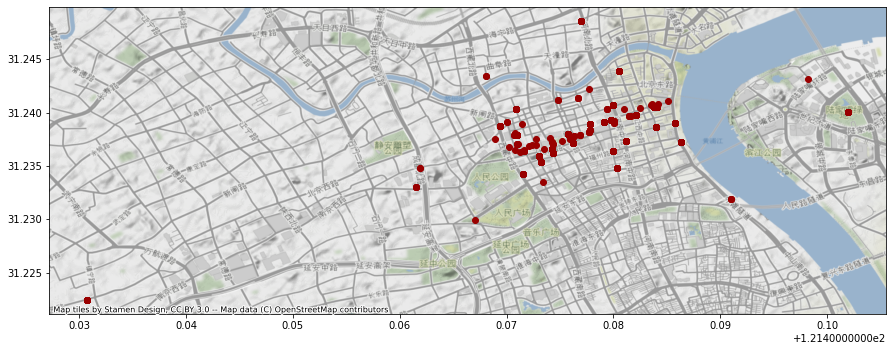

In [43]:
import contextily as cx
ax = gdf.plot(figsize = (15,10),color = '#990000')
cx.add_basemap(ax,crs = gdf.crs.to_string())

## mobike speed experiment

To provide a new option on a housing website, a real estate company contact you and ask you how far from a subway station is a 10min bike ride. To answer this question you need to know the speed at wich people bike in Shanghai in average. Fortunately you have a large dataset with bike travel that could provide this exact information. So you are gonna get the average biking speed of a mobike user in Shanghai. 

🤔 step 1 load the mobike dataframe into a normal pandas dataframe

In [7]:
df_mobike = pd.read_csv('../data/UTSEUS-MOBIKE-shanghai_full.csv')
df_mobike

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,1,324731,7541,2016-08-28 00:00,121.490,31.280,2016-08-28 00:08,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1..."
1,6,288841,4427,2016-08-28 00:00,121.462,31.313,2016-08-28 00:17,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1..."
2,8,315873,6474,2016-08-28 00:00,121.416,31.154,2016-08-28 00:14,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1..."
3,10,93155,12616,2016-08-28 00:00,121.436,31.320,2016-08-28 00:12,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1..."
4,11,352484,11596,2016-08-28 00:00,121.459,31.325,2016-08-28 00:08,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1..."
...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00,121.452,31.336,2016-08-27 00:12,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1..."
1023599,1807860,7077,11733,2016-08-27 00:00,121.437,31.239,2016-08-27 00:34,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1..."
1023600,1807863,303152,10770,2016-08-26 23:59,121.518,31.291,2016-08-27 00:20,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1..."
1023601,1807864,283994,11009,2016-08-27 00:00,121.532,31.298,2016-08-27 00:19,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1..."


🤔 step 2 adjust the column type for `start_time` and `end_time`

In [8]:
df_mobike['start_time'] = pd.to_datetime(df_mobike.start_time,format = '%Y-%m-%d %H:%M:%S')
df_mobike['end_time'] = pd.to_datetime(df_mobike.end_time,format = '%Y-%m-%d %H:%M:%S')

🤔 step 3 create a new column `elapsed time` with travel time in seconds

In [9]:
df_mobike['elapsed time'] = (df_mobike['end_time']-df_mobike['start_time']).dt.seconds

In [10]:
df_mobike

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480
...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140


🤔 step 4 create a new column `path` and inside, create a `Shapely.geometry.LineString` (see the [manual]  (https://shapely.readthedocs.io/en/stable/manual.html#linestrings))using apply and the coordinate of the starting point and the end point

In [11]:
from shapely.geometry import LineString
import geopandas as gpd

In [12]:
df_mobike['path'] = df_mobike[['start_location_x','start_location_y','end_location_x','end_location_y']].apply(lambda row: LineString([(row.start_location_x,row.start_location_y),(row.end_location_x,row.end_location_y)]), axis = 1)

In [13]:
df_mobike

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time,path
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480,"LINESTRING (121.49 31.28, 121.486 31.273)"
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020,"LINESTRING (121.462 31.313, 121.455 31.315)"
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840,"LINESTRING (121.416 31.154, 121.419 31.156)"
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720,"LINESTRING (121.436 31.32, 121.444 31.31)"
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480,"LINESTRING (121.459 31.325, 121.46 31.315)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720,"LINESTRING (121.452 31.336, 121.45 31.325)"
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040,"LINESTRING (121.437 31.239, 121.423 31.275)"
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260,"LINESTRING (121.518 31.291, 121.506 31.269)"
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140,"LINESTRING (121.532 31.298, 121.539 31.29)"


🤔 step 5 create a geodataframe from this dataframe and set the geometry column to the linestring column `path` and the crs to 4326

In [14]:
df_mobike.path.apply(lambda row: row.coords)

0            ((121.49, 31.28), (121.486, 31.273))
1          ((121.462, 31.313), (121.455, 31.315))
2          ((121.416, 31.154), (121.419, 31.156))
3            ((121.436, 31.32), (121.444, 31.31))
4           ((121.459, 31.325), (121.46, 31.315))
                            ...                  
1023598     ((121.452, 31.336), (121.45, 31.325))
1023599    ((121.437, 31.239), (121.423, 31.275))
1023600    ((121.518, 31.291), (121.506, 31.269))
1023601     ((121.532, 31.298), (121.539, 31.29))
1023602    ((121.367, 31.104), (121.353, 31.098))
Name: path, Length: 1023603, dtype: object

In [15]:
df_mobike.path[1].coords[:]

[(121.462, 31.313), (121.455, 31.315)]

In [16]:
df_mobike.path

0            LINESTRING (121.49 31.28, 121.486 31.273)
1          LINESTRING (121.462 31.313, 121.455 31.315)
2          LINESTRING (121.416 31.154, 121.419 31.156)
3            LINESTRING (121.436 31.32, 121.444 31.31)
4           LINESTRING (121.459 31.325, 121.46 31.315)
                              ...                     
1023598     LINESTRING (121.452 31.336, 121.45 31.325)
1023599    LINESTRING (121.437 31.239, 121.423 31.275)
1023600    LINESTRING (121.518 31.291, 121.506 31.269)
1023601     LINESTRING (121.532 31.298, 121.539 31.29)
1023602    LINESTRING (121.367 31.104, 121.353 31.098)
Name: path, Length: 1023603, dtype: object

In [17]:
import geopandas as gpd
gdf_mobike = gpd.GeoDataFrame(df_mobike,geometry = df_mobike.path ,crs = 4326)

🤔 step 6 convert this geodataframe wuth a new crs, in meters this time (check the [to_crs function](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html?highlight=to_crs#geopandas.GeoDataFrame.to_crs))

In [18]:
gdf_mobike = gdf_mobike.to_crs(3857)

🤔 step 7 create a new column `speed` with the length of your geometry in meters divided by the elapsed time in seconds

In [19]:
gdf_mobike['speed'] = gdf_mobike.apply(lambda row: row.geometry.length / row['elapsed time'],axis = 1)

🤔 step 8 plot the speed as a histogram and get the average speed. 

In [20]:
mean = gdf_mobike['speed'].mean()
std = gdf_mobike['speed'].std()
print(mean,std)

2.162484463318583 11.029415572311361


<AxesSubplot:ylabel='Frequency'>

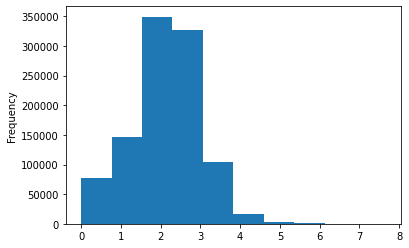

In [21]:
gdf_mobike['speed'][gdf_mobike['speed'] < mean + 0.5 * std].plot(kind = 'hist')

🤔 step 9 using this speed, calculate the distance corresponding to a 10min bike travel for the real estate company

In [22]:
dist = mean * 10 * 60
dist

1297.4906779911498

🤔 step 10 – *optionnal* – the speed can be adjusted and more precise if you use the path in the data instead of the starting and end coordinate. BUT be careful, the coordinates in the path are not ordered so you will have to reorder them. Once you have a clever algorithm, follow the steps again and provide a new estimation for the average speed 

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import LineString
import warnings
warnings.filterwarnings('ignore')

In [3]:
def list_Points(str):
    points = list()
    for path in str.split('#'):
        cor = path.split(',')
        try:
            cor[0]=float(cor[0])
            cor[1]=float(cor[1])
        except ValueError:
            continue
        points.append(Point(cor[0],cor[1]))
#     print(cor)
    return points



In [4]:
def sort_points(point, list_point):
    Point = point
    List_Point = list(list_point)
    for i, p in enumerate(List_Point):
        min_ind = i
        min_len = cal_length(Point,List_Point[i])
        for j in np.arange(i + 1, len(List_Point)):
            if cal_length(Point,List_Point[j]) <= min_len:
                min_ind = j
                min_len = cal_length(Point,List_Point[j])
            else:
                continue
        Point_temp = List_Point[i]
        List_Point[i] = List_Point[min_ind]
        List_Point[min_ind] = Point_temp
    return List_Point

In [5]:
def cal_length(Point1, Point2):
    return LineString([Point1,Point2]).length

In [2]:
df_mobike = pd.read_csv('../data/UTSEUS-MOBIKE-shanghai_full.csv')
df_mobike['start_time'] = pd.to_datetime(df_mobike.start_time,format = '%Y-%m-%d %H:%M:%S')
df_mobike['end_time'] = pd.to_datetime(df_mobike.end_time,format = '%Y-%m-%d %H:%M:%S')
df_mobike['elapsed time'] = (df_mobike['end_time']-df_mobike['start_time']).dt.seconds

df_mobike_new = df_mobike[['track','elapsed time']]
df_mobike_new['start_point'] = df_mobike.apply(lambda rows: Point(rows.start_location_x,rows.start_location_y),axis = 1)
df_mobike_new['done'] = 0
df_mobike_new['speed'] = 0.0

In [ ]:
while( len(df_mobike_new[df_mobike_new.done == 0]) > 0 ):
    
    row = df_mobike_new[df_mobike_new.done == 0].sample(1)
    row_id = row.index.to_list()[0]
    row.track = row.track.apply(str).apply(list_Points)
#     print(row)
#     sort_points(row.start_point.to_list()[0],row.track)
#     print(row['start_point'].to_list()[0])
#     print(type(row['start_point'].to_list()[0]))
    row['correct_path'] = row.apply(lambda rows: sort_points(rows.start_point,rows.track), axis = 1)
    try:
        ls = row.apply(lambda rows: LineString(rows.correct_path), axis = 1)
    except ValueError:
        df_mobike_new.at[row_id,'done'] = 2
        continue
#     print(ls)
#     print(type(row['correct_path']))

#     df_mobike_new.at[row_id,'correct_path'] = row['correct_path'] 
#     df_mobike_new.at[row_id,'correct_LineString'] = row.apply(lambda rows: LineString(rows.correct_path), axis = 1)
    gdf = gpd.GeoDataFrame(ls,geometry = ls,crs = 4326)
    gdf = gdf.to_crs(3857)
#     print(gdf.length)
#     print(gdf.length)
#     print(df_mobike_new.at[row_id,'elapsed time'])
    df_mobike_new.at[row_id,'speed'] = gdf.length / df_mobike_new.at[row_id,'elapsed time']
    df_mobike_new.at[row_id,'done'] = 1


In [59]:
len(df_mobike_new[df_mobike_new.done == 1])/len(df_mobike_new)

0.05228491905553227

In [60]:
df_mobike_new.to_csv(path_or_buf = './df_mobike_speed')

<ipython-input-28-3100e1855230>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mobike_new[df_mobike_new.speed != 0 ][df_mobike_new.speed < 10].speed.plot(kind = 'hist')


<AxesSubplot:ylabel='Frequency'>

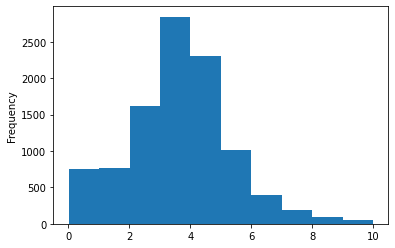

In [28]:
df_mobike_new[df_mobike_new.speed != 0 ][df_mobike_new.speed < 10].speed.plot(kind = 'hist')

In [29]:
df_mobike_new[df_mobike_new.speed != 0 ].speed.mean()

3.9454675940035773